In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_06 import *

In [3]:
torch.__version__

'1.1.0'

## ConvNet

Let's get the data and training interface from where we left in the last notebook.

In [4]:
x_train,y_train,x_valid,y_valid = get_data()

x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [5]:
mnist_view = view_tfm(1,28,28)
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, mnist_view)]

In [6]:
nfs = [8,16,32,64,64]

In [7]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [8]:
%time run.fit(2, learn)

train: [1.62535734375, tensor(0.4658, device='cuda:0')]
valid: [0.27002763671875, tensor(0.9175, device='cuda:0')]
train: [0.25644728515625, tensor(0.9213, device='cuda:0')]
valid: [0.12139595947265625, tensor(0.9628, device='cuda:0')]
CPU times: user 4.61 s, sys: 1.26 s, total: 5.87 s
Wall time: 5.77 s


## Batchnorm

### Custom

Let's start by building our own `BatchNorm` layer from scratch.

In [42]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    def update_stats(self, x):
        m = x.mean(dim=(0,2,3), keepdim=True)
        v = x.var (dim=(0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_ (v, self.mom)
        return m,v
        
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v = self.means,self.vars
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds

if print out x.shape

    class BatchNorm(nn.Module):
        ...
        def update_stats(self, x):
            m = x.mean(dim=(0,2,3), keepdim=True)
            v = x.var (dim=(0,2,3), keepdim=True)
            print(x.shape, m.shape, v.shape)
            self.means.lerp_(m, self.mom)
            self.vars.lerp_ (v, self.mom)
            return m,v

          
    torch.Size([512, 8, 14, 14]) torch.Size([1, 8, 1, 1]) torch.Size([1, 8, 1, 1])
    torch.Size([512, 16, 7, 7]) torch.Size([1, 16, 1, 1]) torch.Size([1, 16, 1, 1])
    torch.Size([512, 32, 4, 4]) torch.Size([1, 32, 1, 1]) torch.Size([1, 32, 1, 1])
    torch.Size([512, 64, 2, 2]) torch.Size([1, 64, 1, 1]) torch.Size([1, 64, 1, 1])
    torch.Size([512, 64, 1, 1]) torch.Size([1, 64, 1, 1]) torch.Size([1, 64, 1, 1])
    torch.Size([512, 8, 14, 14]) torch.Size([1, 8, 1, 1]) torch.Size([1, 8, 1, 1])
    torch.Size([512, 16, 7, 7]) torch.Size([1, 16, 1, 1]) torch.Size([1, 16, 1, 1])
    torch.Size([512, 32, 4, 4]) torch.Size([1, 32, 1, 1]) torch.Size([1, 32, 1, 1])
            
dimensions:            
            
    dim=(0,2,3)
    0: batch
    1: channel
    2,3: x,y coordinates
    
each batch get n_channel m's and v's

In [43]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # No bias needed if using bn
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)

In [44]:
#export
def init_cnn_(m, f):
    if isinstance(m, nn.Conv2d):
        f(m.weight, a=0.1)
        if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
    for l in m.children(): init_cnn_(l, f)

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)

def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

We can then use it in training and see how it helps keep the activations means to 0 and the std to 1.

In [45]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs)

train: [0.2661073046875, tensor(0.9169, device='cuda:0')]
valid: [0.13358292236328126, tensor(0.9615, device='cuda:0')]


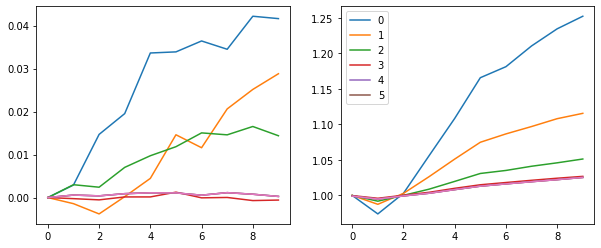

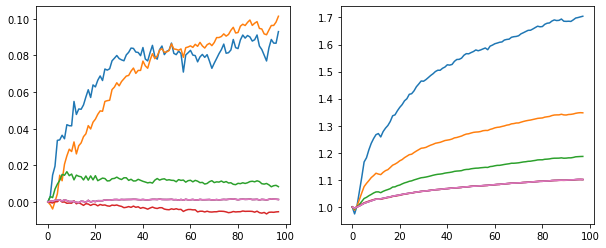

In [46]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)

In [47]:
learn,run = get_learn_run(nfs, data, 1.0, conv_layer, cbs=cbfs)

In [48]:
%time run.fit(3, learn)

train: [0.25040349609375, tensor(0.9219, device='cuda:0')]
valid: [0.10081878662109375, tensor(0.9696, device='cuda:0')]
train: [0.0766608349609375, tensor(0.9766, device='cuda:0')]
valid: [0.11499014892578124, tensor(0.9641, device='cuda:0')]
train: [0.0544217529296875, tensor(0.9834, device='cuda:0')]
valid: [0.07200562744140625, tensor(0.9787, device='cuda:0')]
CPU times: user 3.25 s, sys: 31 ms, total: 3.28 s
Wall time: 3.28 s


### Builtin batchnorm

In [49]:
#export
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [50]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs)

In [51]:
%time run.fit(3, learn)

train: [0.27570626953125, tensor(0.9177, device='cuda:0')]
valid: [0.194866064453125, tensor(0.9383, device='cuda:0')]
train: [0.078471103515625, tensor(0.9762, device='cuda:0')]
valid: [0.09229315795898438, tensor(0.9736, device='cuda:0')]
train: [0.0554864697265625, tensor(0.9826, device='cuda:0')]
valid: [0.0829701171875, tensor(0.9745, device='cuda:0')]
CPU times: user 2.97 s, sys: 61.3 ms, total: 3.03 s
Wall time: 3.03 s


### With scheduler

Now let's add the usual warm-up/annealing.

In [52]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.6, 2.), sched_lin(2., 0.1)]) 

In [53]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched)])

In [54]:
run.fit(8, learn)

train: [0.3109803515625, tensor(0.9117, device='cuda:0')]
valid: [0.11074984130859375, tensor(0.9659, device='cuda:0')]
train: [0.09011359375, tensor(0.9720, device='cuda:0')]
valid: [0.24819228515625, tensor(0.9132, device='cuda:0')]
train: [0.0658261669921875, tensor(0.9793, device='cuda:0')]
valid: [0.07636080932617187, tensor(0.9778, device='cuda:0')]
train: [0.0417239453125, tensor(0.9872, device='cuda:0')]
valid: [0.0703751708984375, tensor(0.9807, device='cuda:0')]
train: [0.0279752197265625, tensor(0.9912, device='cuda:0')]
valid: [0.0535171875, tensor(0.9838, device='cuda:0')]
train: [0.017751724853515626, tensor(0.9945, device='cuda:0')]
valid: [0.05072969970703125, tensor(0.9856, device='cuda:0')]
train: [0.011022799072265626, tensor(0.9975, device='cuda:0')]
valid: [0.0461005859375, tensor(0.9868, device='cuda:0')]
train: [0.007281674194335937, tensor(0.9987, device='cuda:0')]
valid: [0.045945068359375, tensor(0.9874, device='cuda:0')]


## More norms

### Layer norm

From [the paper](https://arxiv.org/abs/1607.06450): "*batch normalization cannot be applied to online learning tasks or to extremely large distributed models where the minibatches have to be small*".

General equation for a norm layer with learnable affine:

$$y = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta$$

The difference with BatchNorm is
1. we don't keep a moving average
2. we don't average over the batches dimension but over the hidden dimension, so it's independent of the batch size

In [60]:
class LayerNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add  = nn.Parameter(tensor(0.))

    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True)
        v = x.var ((1,2,3), keepdim=True)
        x = (x-m) / ((v+self.eps).sqrt())
        return x*self.mult + self.add

if print out x.shape

    class LayerNorm(nn.Module):
        __constants__ = ['eps']
        def __init__(self, eps=1e-5):
            super().__init__()
            self.eps = eps
            self.mult = nn.Parameter(tensor(1.))
            self.add  = nn.Parameter(tensor(0.))

        def forward(self, x):
            m = x.mean((1,2,3), keepdim=True)
            v = x.var ((1,2,3), keepdim=True)
            x = (x-m) / ((v+self.eps).sqrt())
            print(x.shape, m.shape, v.shape)
            return x*self.mult + self.add
        
    torch.Size([512, 8, 14, 14]) torch.Size([512, 1, 1, 1]) torch.Size([512, 1, 1, 1])
    torch.Size([512, 16, 7, 7]) torch.Size([512, 1, 1, 1]) torch.Size([512, 1, 1, 1])
    torch.Size([512, 32, 4, 4]) torch.Size([512, 1, 1, 1]) torch.Size([512, 1, 1, 1])
    torch.Size([512, 64, 2, 2]) torch.Size([512, 1, 1, 1]) torch.Size([512, 1, 1, 1])
    torch.Size([512, 64, 1, 1]) torch.Size([512, 1, 1, 1]) torch.Size([512, 1, 1, 1])
    torch.Size([512, 8, 14, 14]) torch.Size([512, 1, 1, 1]) torch.Size([512, 1, 1, 1])
    torch.Size([512, 16, 7, 7]) torch.Size([512, 1, 1, 1]) torch.Size([512, 1, 1, 1])            
dimensions:            
            
    dim=(1,2,3)
    0: batch
    1: channel
    2,3: x,y coordinates

each layer image get one m and one v

In [61]:
def conv_ln(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(LayerNorm())
    return nn.Sequential(*layers)

In [64]:
learn,run = get_learn_run(nfs, data, 0.8, conv_ln, cbs=cbfs)

In [65]:
%time run.fit(3, learn)

train: [nan, tensor(0.1172, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 3.57 s, sys: 24.6 ms, total: 3.59 s
Wall time: 3.59 s


*Thought experiment*: can this distinguish foggy days from sunny days (assuming you're using it before the first conv)?

### Instance norm

From [the paper](https://arxiv.org/abs/1607.08022): 

The key difference between **contrast** and batch normalization is that the latter applies the normalization to a  whole batch of images instead for single ones:

\begin{equation}\label{eq:bnorm}
    y_{tijk} =  \frac{x_{tijk} - \mu_{i}}{\sqrt{\sigma_i^2 + \epsilon}},
    \quad
    \mu_i = \frac{1}{HWT}\sum_{t=1}^T\sum_{l=1}^W \sum_{m=1}^H x_{tilm},
    \quad
    \sigma_i^2 = \frac{1}{HWT}\sum_{t=1}^T\sum_{l=1}^W \sum_{m=1}^H (x_{tilm} - mu_i)^2.
\end{equation}

In order to combine the effects of instance-specific normalization and batch normalization, we propose to replace the latter by the *instance normalization* (also known as *contrast normalization*) layer:

\begin{equation}\label{eq:inorm}
    y_{tijk} =  \frac{x_{tijk} - \mu_{ti}}{\sqrt{\sigma_{ti}^2 + \epsilon}},
    \quad
    \mu_{ti} = \frac{1}{HW}\sum_{l=1}^W \sum_{m=1}^H x_{tilm},
    \quad
    \sigma_{ti}^2 = \frac{1}{HW}\sum_{l=1}^W \sum_{m=1}^H (x_{tilm} - mu_{ti})^2.
\end{equation}

In [74]:
class InstanceNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, nf, eps=1e-0):
        super().__init__()
        self.eps = eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))

    def forward(self, x):
        m = x.mean((2,3), keepdim=True)
        v = x.var ((2,3), keepdim=True)
        res = (x-m) / ((v+self.eps).sqrt())
        return res*self.mults + self.adds

    class InstanceNorm(nn.Module):
        __constants__ = ['eps']
        def __init__(self, nf, eps=1e-0):
            super().__init__()
            self.eps = eps
            self.mults = nn.Parameter(torch.ones (nf,1,1))
            self.adds  = nn.Parameter(torch.zeros(nf,1,1))

        def forward(self, x):
            m = x.mean((2,3), keepdim=True)
            v = x.var ((2,3), keepdim=True)
            print(x.shape, m.shape, v.shape)
            res = (x-m) / ((v+self.eps).sqrt())
            return res*self.mults + self.adds



    torch.Size([512, 8, 14, 14]) torch.Size([512, 8, 1, 1]) torch.Size([512, 8, 1, 1])
    torch.Size([512, 16, 7, 7]) torch.Size([512, 16, 1, 1]) torch.Size([512, 16, 1, 1])
    torch.Size([512, 32, 4, 4]) torch.Size([512, 32, 1, 1]) torch.Size([512, 32, 1, 1])
    torch.Size([512, 64, 2, 2]) torch.Size([512, 64, 1, 1]) torch.Size([512, 64, 1, 1])
    torch.Size([512, 64, 1, 1]) torch.Size([512, 64, 1, 1]) torch.Size([512, 64, 1, 1])
    torch.Size([512, 8, 14, 14]) torch.Size([512, 8, 1, 1]) torch.Size([512, 8, 1, 1])
    torch.Size([512, 16, 7, 7]) torch.Size([512, 16, 1, 1]) torch.Size([512, 16, 1, 1])
    torch.Size([512, 32, 4, 4]) torch.Size([512, 32, 1, 1]) torch.Size([512, 32, 1, 1])

dimensions:            
            
    dim=(2,3)
    0: batch
    1: channel
    2,3: x,y coordinates (H,W)

each layer image gets n_channels m's and v's

In [75]:
def conv_in(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(InstanceNorm(nf))
    return nn.Sequential(*layers)

In [76]:
learn,run = get_learn_run(nfs, data, 0.1, conv_in, cbs=cbfs)

In [77]:
%time run.fit(3, learn)

train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 3.76 s, sys: 21.5 ms, total: 3.78 s
Wall time: 3.78 s


*Question*: why can't this classify anything?

Lost in all those norms? The authors from the [group norm paper](https://arxiv.org/pdf/1803.08494.pdf) have you covered:

![Various norms](images/norms.png)

### Group norm

*From the PyTorch docs:*

`GroupNorm(num_groups, num_channels, eps=1e-5, affine=True)`

The input channels are separated into `num_groups` groups, each containing
``num_channels / num_groups`` channels. The mean and standard-deviation are calculated
separately over the each group. $\gamma$ and $\beta$ are learnable
per-channel affine transform parameter vectors of size `num_channels` if
`affine` is `True`.

This layer uses statistics computed from input data in both training and
evaluation modes.

Args:
-    `num_groups (int)`: number of groups to separate the channels into
-    `num_channels (int)`: number of channels expected in input
-    `eps`: a value added to the denominator for numerical stability. Default: `1e-5`
-    `affine`: a boolean value that when set to ``True``, this module
        has learnable per-channel affine parameters initialized to ones (for weights)
        and zeros (for biases). Default: ``True``.

Shape:
- Input: `(N, num_channels, *)`
- Output: `(N, num_channels, *)` (same shape as input)

Examples::

    >>> input = torch.randn(20, 6, 10, 10)
    >>> # Separate 6 channels into 3 groups
    >>> m = nn.GroupNorm(3, 6)
    >>> # Separate 6 channels into 6 groups (equivalent with InstanceNorm)
    >>> m = nn.GroupNorm(6, 6)
    >>> # Put all 6 channels into a single group (equivalent with LayerNorm)
    >>> m = nn.GroupNorm(1, 6)
    >>> # Activating the module
    >>> output = m(input)

## Fix small batch sizes

### What's the problem?

When we compute the statistics (mean and std) for a BatchNorm Layer on a small batch, it is possible that we get a standard deviation very close to 0. because there aren't many samples (the variance of one thing is 0. since it's equal to its mean).

In [78]:
data = DataBunch(*get_dls(train_ds, valid_ds, 2), c)

In [79]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [80]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [81]:
%time run.fit(1, learn)

train: [2.35083015625, tensor(0.1661, device='cuda:0')]
valid: [79652021.8624, tensor(0.1660, device='cuda:0')]
CPU times: user 1min 37s, sys: 668 ms, total: 1min 38s
Wall time: 1min 38s


### Running Batch Norm

To solve this problem we introduce a Running BatchNorm that uses smoother running mean and variance for the mean and std.

In [82]:
class RunningBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('sums', torch.zeros(1,nf,1,1))
        self.register_buffer('sqrs', torch.zeros(1,nf,1,1))
        self.register_buffer('batch', tensor(0.))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('step', tensor(0.))
        self.register_buffer('dbias', tensor(0.))

    def update_stats(self, x):
        bs,nc,*_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0,2,3)
        s = x.sum(dims, keepdim=True)
        ss = (x*x).sum(dims, keepdim=True)
        c = self.count.new_tensor(x.numel()/nc)
        mom1 = 1 - (1-self.mom)/math.sqrt(bs-1)
        self.mom1 = self.dbias.new_tensor(mom1)
        self.sums.lerp_(s, self.mom1)
        self.sqrs.lerp_(ss, self.mom1)
        self.count.lerp_(c, self.mom1)
        self.dbias = self.dbias*(1-self.mom1) + self.mom1
        self.batch += bs
        self.step += 1

    def forward(self, x):
        if self.training: self.update_stats(x)
        sums = self.sums
        sqrs = self.sqrs
        c = self.count
        if self.step<100:
            sums = sums / self.dbias
            sqrs = sqrs / self.dbias
            c    = c    / self.dbias
        means = sums/c
        vars = (sqrs/c).sub_(means*means)
        if bool(self.batch < 20): vars.clamp_min_(0.01)
        x = (x-means).div_((vars.add_(self.eps)).sqrt())
        return x.mul_(self.mults).add_(self.adds)

NB: the calculation of `self.dbias` in the version in the lesson video was incorrect. The correct version is in the cell above. Also, we changed how we calculated `self.mom1` to something that it more mathematically appropriate. These two changes improved the accuracy from 91% (in the video) to 97%+ (shown below)!

In [83]:
def conv_rbn(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(RunningBatchNorm(nf))
    return nn.Sequential(*layers)

In [84]:
learn,run = get_learn_run(nfs, data, 0.4, conv_rbn, cbs=cbfs)

In [85]:
%time run.fit(1, learn)

train: [0.385081484375, tensor(0.8968, device='cuda:0')]
valid: [0.19900653076171876, tensor(0.9648, device='cuda:0')]
CPU times: user 4min 6s, sys: 1.38 s, total: 4min 8s
Wall time: 4min 8s


This solves the small batch size issue!

### What can we do in a single epoch?

Now let's see with a decent batch size what result we can get.

In [86]:
data = DataBunch(*get_dls(train_ds, valid_ds, 32), c)

In [87]:
learn,run = get_learn_run(nfs, data, 0.8, conv_rbn, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched_lin(1., 0.2))])

In [88]:
%time run.fit(1, learn)

train: [0.17291671875, tensor(0.9474, device='cuda:0')]
valid: [0.51443291015625, tensor(0.9701, device='cuda:0')]
CPU times: user 15.8 s, sys: 58.1 ms, total: 15.9 s
Wall time: 15.9 s


### Simplified RunningBatchNorm

It turns out we don't actually need to debias - because, for instance, dividing a debiased sum by a debiased count is the same as dividing a *biased* sum by a *biased* count! So we can remove all the debiasing stuff and end up with a simpler class. Also, we should save `eps` as a buffer since it impacts the calculation. (Thanks to Stas Bekman for noticing these.) Also we can slightly change the final calculation in `forward` with one that uses `factor` and `offset` to reduce the amount of broadcasting required. (Thanks to Tom Viehmann for this suggestion.)

In [89]:
#export
class RunningBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom, self.eps = mom, eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('sums', torch.zeros(1,nf,1,1))
        self.register_buffer('sqrs', torch.zeros(1,nf,1,1))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('factor', tensor(0.))
        self.register_buffer('offset', tensor(0.))
        self.batch = 0
        
    def update_stats(self, x):
        bs,nc,*_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0,2,3)
        s    = x    .sum(dims, keepdim=True)
        ss   = (x*x).sum(dims, keepdim=True)
        c    = s.new_tensor(x.numel()/nc)
        mom1 = s.new_tensor(1 - (1-self.mom)/math.sqrt(bs-1))
        self.sums .lerp_(s , mom1)
        self.sqrs .lerp_(ss, mom1)
        self.count.lerp_(c , mom1)
        self.batch += bs
        means = self.sums/self.count
        varns = (self.sqrs/self.count).sub_(means*means)
        if bool(self.batch < 20): varns.clamp_min_(0.01)
        self.factor = self.mults / (varns+self.eps).sqrt()
        self.offset = self.adds - means*self.factor
        
    def forward(self, x):
        if self.training: self.update_stats(x)
        return x*self.factor + self.offset

In [90]:
learn,run = get_learn_run(nfs, data, 0.8, conv_rbn, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched_lin(1., 0.2))])

In [91]:
%time run.fit(1, learn)

train: [0.153647880859375, tensor(0.9530, device='cuda:0')]
valid: [0.136031982421875, tensor(0.9783, device='cuda:0')]
CPU times: user 13.8 s, sys: 92 ms, total: 13.9 s
Wall time: 13.9 s


## Export

In [93]:
nb_auto_export()

<IPython.core.display.Javascript object>